# Determining Starbucks Demographics

In this notebook I will use the data cleaning performed in the processing notebook to attempt to determine what the core demographics of Starbucks membership are in a effort to predict spend and ultimately improve the targeting of Starbucks offers;

This process will involve running an unsupervised learning method to cluster the data into groups based on information provided in their profiles including age, gender, income and length of membership. It will also take into account how much users normally spend at Starbucks on a per transaction basis.

First, I will perform some further processing of the data to prepare it for the model (standard scalars etc.). Then I will run a K-means ml model to cluster the data and determine what the optimum number of clusters describes the demographics appropriately. After this I will describe some interesting findings from the results to gain data understanding before the final step of this project in the second half of the modeling to predict user spend.

### Imports

In [197]:
import sbpkg

In [200]:
# import general functions
import pandas as pd
import numpy as np
import json

# import functions for modelling
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# plotting functions
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import matplotlib.style as style
import matplotlib.gridspec as gridspec
from pandas.plotting import register_matplotlib_converters
from matplotlib import ticker

# Saving the ML model
import joblib

# import the cleaning package
import sbpkg as sb

### Functions

### Global Variables

In [193]:
# read in the different datasources
portfolio_df = pd.read_json('/content/portfolio.json', lines=True)
profile_df = pd.read_json('/content/profile.json', lines=True)
transcript_df = pd.read_json('/content/transcript.json', lines=True)

In [166]:
clean_trans_df

,offer completed,offer received,offer viewed,transaction,amount,offer_id,person,time,id
0,0,1,0,0,0,1,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,0,1,0,0,0,1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,0,1,0,0,0,1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,0,1,0,0,0,1,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,0,1,0,0,0,1,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...,...,...
306529,0,0,0,1,1,0,b3a1272bc9904337b331bf348c3e8c17,714,1.59
306530,0,0,0,1,1,0,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
306531,0,0,0,1,1,0,a00058cf10334a308c68e7631c529907,714,3.61
306532,0,0,0,1,1,0,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53


### Run Cleaning Functions

In [216]:
import clbg as cl

In [217]:
# run the initial cleaning on each dataset
clean_prof_df = cl.clean_profile_data(profile_df)

clean_port_df = sb.clean_portfolio_data(portfolio_df)
clean_trans_df = sb.clean_transcript_data(transcript_df)

# calculates the uninfluenced transactions for the modeling
uninflunced_trans = sb.norm_transactions(clean_trans_df, clean_port_df)

# process the user data to create the modeling input
user_data = sb.user_transactions(clean_prof_df, uninflunced_trans)
user_data.head()

,female,male,other,unknown gender,age,person,member joined,income,total transactions,total spend,spend per trans,spend per day,membership length
0,0,0,0,1,0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,9,20.40,2.266667,0.680000,76.0
1,1,0,0,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3,77.01,25.670000,2.567000,54.0
2,0,0,0,1,0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,5,10.21,2.042000,0.340333,2.0
3,1,0,0,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4,89.99,22.497500,2.999667,63.0
4,0,0,0,1,0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,3,4.65,1.550000,0.155000,51.0


In [165]:
transcript_df

,person,event,value,time,interaction_value,id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,offer id,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,offer id,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,amount,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,amount,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,amount,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,amount,3.53


### Demographics Modelling

Now that I have the demographics input I can apply some final processing prior to modelling.

Here I will apply feature scaling to the input dataset. This is mainly to adjust the income column as it has a very large range of 0-120,000 which if not scaled will impact the behaviour of clustering. This is because the most amount of reduction in distance to cluster center will come from just grouping users based on income.

In [132]:
# remove unwanted columns
demographics_input = user_data.drop(columns=['member joined','person', 
                                             'total transactions', 'total spend'])

# Apply feature scaling to the demographics data.
scaler = StandardScaler()
scaler.fit(demographics_input)
input_demo_data = scaler.transform(demographics_input)

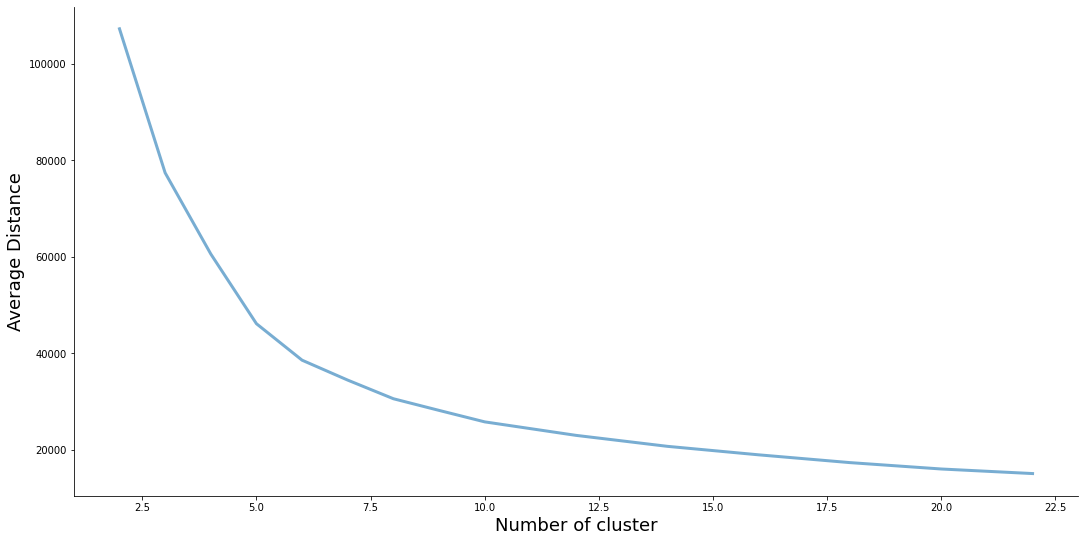

In [133]:
# run k-means over different cluster counts to see the best number of groups to split our demographic data into
# creates plot
fig, ax = plt.subplots(figsize=(18,9))

# loop through all of the different cluster counts
ad = {}
cluster_counts = [2,3,4,5,6,7,8,9,10,12,14,16,18,20,22]
for x in cluster_counts:
    kmeans = KMeans(n_clusters=x, max_iter=1000).fit(input_demo_data)
    ad[x] = kmeans.inertia_
    
# plot the average distance to the center of the clusters 
ax.plot(list(ad.keys()), list(ad.values()), linewidth=3, alpha=0.6)

# label axis
ax.set_xlabel("Number of cluster", fontsize=18)
ax.set_ylabel("Average Distance", fontsize=18)

# Removes spines and changes layout to tight
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# show plot
plt.show()

Plotting the average distance to centroid  by the number of clusters is the best way to determine what the optimum number of cluster should be. This optimum point is called the 'knee' of the graph and shows where the most amount of information gain for the least amount of clusters are. On the graph above we can see a relatively clear knee at around 6 clusters and another small one at 8 where there are changes in information. I've decided to use 8 clusters as the biggest deciding factor on splitting clusters was found be 'Gender' probably as it's a categorical variable. Having a larger number of clusters means I get some splits on other features such as 'Income' and 'age' also.

In [44]:
# create and run the model
final_kmeans = KMeans(n_clusters=8, max_iter=1000).fit(input_demo_data)
predict = final_kmeans.predict(input_demo_data)

# add the pedictions for the clustering onto the original dataset
demographics_output = demographics_input
demographics_output['cluster'] = predict

We can now use the model to predict which clusters users will be grouped into as shown above. I have performed an in depth analysis below into how each of the clusters has been split out.

### Demographics Analysis

In [45]:
demographics_output.groupby('cluster').mean()

,female,male,other,unknown gender,age,income,spend per trans,spend per day,membership length
cluster,,,,,,,,,
0,0.029461,0.970539,0.0,0.0,49.956643,54693.162868,8.001059,1.957591,178.424680
1,1.000000,0.000000,0.0,0.0,50.826657,53776.037873,10.116779,2.024708,57.920248
2,0.000000,0.000000,0.0,1.0,0.000000,0.000000,2.352779,0.452499,70.869565
3,0.000000,1.000000,0.0,0.0,47.620905,50971.492873,5.882919,1.083544,34.988247
4,0.000000,0.000000,1.0,0.0,54.507614,62649.746193,14.529618,3.232132,71.472081
5,1.000000,0.000000,0.0,0.0,63.528327,86747.234328,23.072856,4.311474,87.062353
6,0.000000,1.000000,0.0,0.0,60.442159,81476.435304,22.104290,4.463714,74.928021
7,0.502793,0.497207,0.0,0.0,56.983240,79050.279330,129.113700,25.947760,81.608939


In [47]:
demographics_output.groupby('cluster')['income'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1799.0,54693.162868,15187.567106,30000.0,42000.0,54000.0,65000.0,100000.0
1,2746.0,53776.037873,13614.083345,30000.0,42000.0,54000.0,64000.0,98000.0
2,2070.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,3999.0,50971.492873,12983.064643,30000.0,40000.0,51000.0,61000.0,98000.0
4,197.0,62649.746193,18739.191781,30000.0,50000.0,60000.0,78000.0,100000.0
5,2983.0,86747.234328,16500.852717,33000.0,75000.0,86000.0,99000.0,120000.0
6,2334.0,81476.435304,17250.508033,31000.0,70000.0,81000.0,93000.0,120000.0
7,179.0,79050.279330,17596.371480,36000.0,67000.0,76000.0,91000.0,119000.0


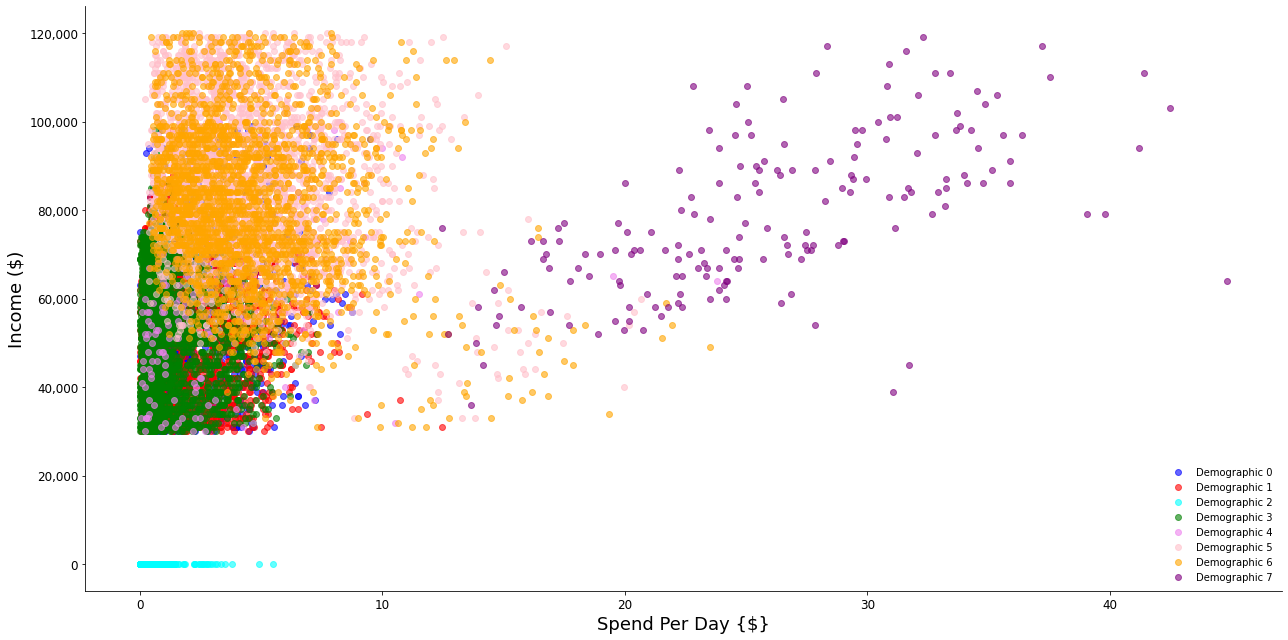

In [48]:
# creates plot
fig, ax = plt.subplots(figsize=(18,9))

for demographic in [0,1,2,3,4,5,6,7]:
    # input data 
    df = demographics_output[demographics_output['cluster'] == demographic]

    # creates a list of colors
    colors = ['blue','red','cyan','green','violet','pink','orange','purple']

    # plot selected demographics
    ax.scatter(df['spend per day'], df['income'], 
               color=colors[demographic], label=f'Demographic {demographic}',
              alpha=0.6)
    
# show the plot legend
ax.legend(loc=4, frameon=False)

# set x label
ax.set_xlabel('Spend Per Day {$}', fontsize=18)

# set y label
ax.set_ylabel('Income ($)', fontsize=18)

# set size of the axis params
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# Adds the comma into y labels
ax.get_yaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Removes spines and changes layout to tight
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# show/close
plt.show()

In [49]:
demographics_output.groupby('cluster')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1799.0,49.956643,17.551048,18.0,37.0,51.0,63.0,98.0
1,2746.0,50.826657,17.727460,18.0,37.0,51.0,63.0,101.0
2,2070.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
3,3999.0,47.620905,17.500213,18.0,33.0,47.0,61.0,98.0
4,197.0,54.507614,16.537101,20.0,43.0,55.0,67.0,100.0
5,2983.0,63.528327,13.632296,19.0,54.0,62.0,73.0,101.0
6,2334.0,60.442159,13.986548,18.0,52.0,60.0,70.0,100.0
7,179.0,56.983240,16.848124,18.0,46.5,58.0,67.5,97.0


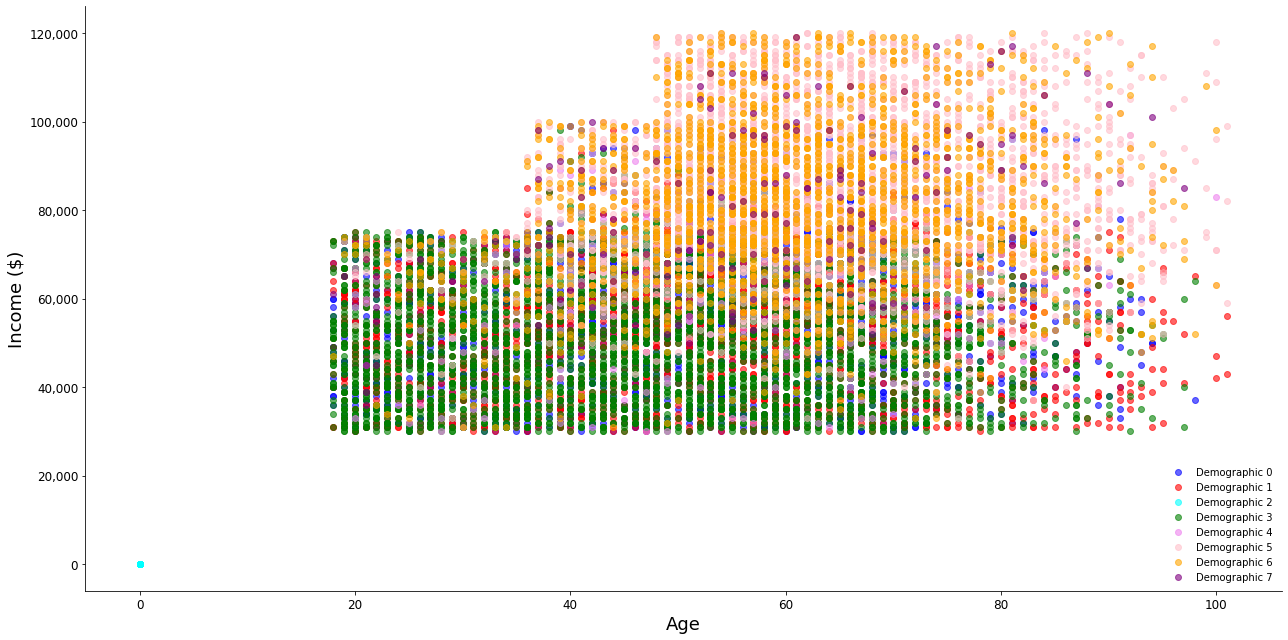

In [50]:
# creates plot
fig, ax = plt.subplots(figsize=(18,9))

for demographic in [0,1,2,3,4,5,6,7]:
    # input data 
    df = demographics_output[demographics_output['cluster'] == demographic]

    # creates a list of colors
    colors = ['blue','red','cyan','green','violet','pink','orange','purple']

    # plot selected demographics
    ax.scatter(df['age'], df['income'], 
               color=colors[demographic], label=f'Demographic {demographic}',
              alpha=0.6)
    
# show the plot legend
ax.legend(loc=4, frameon=False)

# set x label
ax.set_xlabel('Age', fontsize=18)

# set y label
ax.set_ylabel('Income ($)', fontsize=18)

# set size of the axis params
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

# Adds the comma into y labels
ax.get_yaxis().set_major_formatter(
ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# Removes spines and changes layout to tight
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# show/close
plt.show()

Above shows that we have 8 clusters with the majority being divided primarily on Gender as only two of the clusters contain users with mixed genders. Other key dividing features in the data appear to be spend, age and income.

There are two clusters with males only 1 & 7 respectively. They appear to have been split on all of the three factors above of spend, age and income. This makes sense as younger people tend to have a lower income and therefore will probably spend less on Starbucks coffee. Similarly there are two clusters for women that are split along similar lines (spend, age and income) these are clusters 0 & 5.

Users who put 'other' or have an unknown gender have been put into separate clusters of their own 4 and 2 respectively. It's worth noting that users who didn't specify their gender had very little spend at all this could be because they aren't as engaged users who haven't filled in their personal information.

Finally there are two mixed clusters with both men & women in number 3 & 6. Cluster number 3 appears to show very well off but high spending users. Whereas cluster 6 appears to show young, lower earning users who have had membership for a long time. This could indicate that they are regular customers who spend an average amount each week.

### Output the demographics model

Now that we have our demographic model we can save it and create a function to preform the clustering on any new dataset provided but also to use in future notebooks.

In [51]:
joblib.dump(final_kmeans, 'kmeans_demographic_model.pkl')

['kmeans_demographic_model.pkl']

In [58]:
# Create a function below to read in the model and predict the demographic for other datasets
def predict_demographic(profile_data, demographic_model='kmeans_demographic_model.pkl'):
    """
    this can be used to predict the demographics of group of consumers
    """
    # Reads the volume model 
    final_kmeans = joblib.load(demographic_model)
    
    # remove unwanted columns
    profile_data_input = profile_data.drop(columns=['member joined',
                                              'person', 
                                              'total transactions', 
                                              'total spend'])
    
    # process the profile data
    scaler = StandardScaler()
    scaler.fit(profile_data_input)
    input_demo_data = scaler.transform(profile_data_input)
    
    # predict the demographics   
    predictions = final_kmeans.predict(input_demo_data)
    
    # add the pedictions for the clustering onto the original dataset
    updated_dataframe = profile_data
    updated_dataframe['demographic'] = predictions
    
    return updated_dataframe

In [59]:
uninflunced_trans = sb.norm_transactions(clean_trans_df, clean_port_df)

# process the user data to create the modeling input
user_data = sb.user_transactions(clean_prof_df, uninflunced_trans)

# load in the user spend by day
spd = sb.spend_per_day(clean_trans_df, clean_port_df)
spd.reset_index(inplace=True)

# predict the demographic of all the users in the data
predictions = sb.predict_demographic(user_data)
predictions.head()

,female,male,other,unknown gender,age,person,member joined,income,total transactions,total spend,spend per trans,spend per day,membership length,demographic
0,0,0,0,1,0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,9,20.40,2.266667,0.680000,76.0,2
1,1,0,0,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3,77.01,25.670000,2.567000,54.0,5
2,0,0,0,1,0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,5,10.21,2.042000,0.340333,2.0,2
3,1,0,0,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4,89.99,22.497500,2.999667,63.0,5
4,0,0,0,1,0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,3,4.65,1.550000,0.155000,51.0,2


In [182]:
input_data

spend  ...  demographic
transaction_time person                                   ...             
1.0              0009655768c64bdeb2e877511632db8f    0.0  ...            6
                 0011e0d4e6b944f998e987f904e8c1e5    0.0  ...            4
                 0020c2b971eb4e9188eac86d93036a77    0.0  ...            5
                 0020ccbbb6d84e358d3414a3ff76cffd    0.0  ...            1
                 003d66b6608740288d6cc97a6903f4f0    0.0  ...            1
...                                                  ...  ...          ...
30.0             fff29fb549084123bd046dbc5ceb4faa    0.0  ...            5
                 fff3ba4757bd42088c044ca26d73817a    0.0  ...            5
                 fff7576017104bcc8677a8d63322b5e1    0.0  ...            3
                 fffad4f4828548d1b5583907f2e9906b    0.0  ...            3
                 ffff82501cea40309d5fdd7edcca4a07    0.0  ...            1

[355020 rows x 12 columns]

In [60]:
demographics = predictions[['person','demographic']]

# merge the two datasets so that we have the demographic data for each person
input_data = spd.merge(demographics, on=['person'])
input_data.head()

# only keep the first 23 days so that the last 7 can be used for modeling
input_data = input_data[input_data['transaction_time'] < 24]

# sum the spend & number of offers that 
input_data = input_data.groupby(['transaction_time','person']).sum()
input_data.tail()

spend  ...  demographic
transaction_time person                                    ...             
23.0             fff29fb549084123bd046dbc5ceb4faa   32.57  ...            5
                 fff3ba4757bd42088c044ca26d73817a  414.31  ...            5
                 fff7576017104bcc8677a8d63322b5e1    0.00  ...            3
                 fffad4f4828548d1b5583907f2e9906b    0.00  ...            3
                 ffff82501cea40309d5fdd7edcca4a07    0.00  ...            1

[5 rows x 12 columns]

In [61]:

def create_dummy_days(data):
    """
    this module creates dummies depending on the day of the week
    (this is useful as users behaviour will be different on a weekday vs weekend)
    """
    # add dummies for the days of the week 
    day_of_week = pd.DataFrame(list(data['transaction_time']))
    for n in [1,2,3,4,5,6,7]:
        day_of_week = day_of_week.replace((n+7), n).replace((n+7*2), n).replace((n+7*3), n).replace((n+7*4), n)   
    day_of_week = pd.DataFrame([str(x) for x in day_of_week.iloc[:,0]])
    input_data_test = pd.concat([data, pd.get_dummies(day_of_week)], axis=1, join='inner')
    
    return input_data_test

In [62]:
# To perform testing on the data I will only keep one demographic for now
data = input_data[input_data['demographic'] == 0]

# reset the index
data.reset_index(inplace=True)

# add dummies for the days of the week 
input_data_test = create_dummy_days(data)

# keep only the columns needed
input_data_test = input_data_test.drop(columns=['transaction_time','person','demographic'])
input_data_test.head()

,spend,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,0_1.0,0_2.0,0_3.0,0_4.0,0_5.0,0_6.0,0_7.0
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
2,19.84,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
3,0.23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0


In [64]:
# import functions for modelling
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [65]:
# split the data again into testing and training data
X_train, X_test, y_train, y_test = train_test_split(input_data_test.iloc[:,1:],
                                                   input_data_test.iloc[:,0],
                                                   test_size=.1, 
                                                   random_state=42)

# change the input to a dmatrix to improve optimsation speed for testing
# Note DMatrix was choosen to replace the standard xgboost to reduce the training times
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# calculate the baseline RMSE error, this will be used for evaluation of the model
baseline_pred = np.ones(y_test.shape) * np.mean(y_train)
rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_pred))

print(f"Baseline RMSE is {rmse_baseline}")

Baseline RMSE is 7.090456675351387


In [66]:
# set up the intial parameters for the xgboosting parameterisation
params = {
    'max_depth':5,
    'min_child_weight': 1,
    'eta':.1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma':0.1,
    'objective':'reg:squarederror',
}

In [67]:
# set the rmse value as a very high value
rmse = 1000

# set_ best parameters as nothing
best_parms = None

# sets values for max_depth & min_child_weight
testing_prams = [
    (max_depth, min_child_weight)
    for max_depth in range(7,12)
    for min_child_weight in range(3,8)
]

# loop through both of the variablles
for max_depth, min_child_weight in testing_prams:
    # update the parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Run CV
    results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=14,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    # save the best rmse score
    best_rmse = results['test-rmse-mean'].min()
    
    # print out the results
    print(f"max_depth = {max_depth} | "
          f"min_child_weight = {min_child_weight} | "
          f"rmse = {best_rmse}")
    
    # set the best parameters if they improve on the current rmse
    if best_rmse < rmse:
        rmse = best_rmse
        best_params = (max_depth, min_child_weight)
        
print(f"Best params: "
      f"max_depth = {best_params[0]} | "
      f"min_child_weight = {best_params[1]} | "
      f"rmse = {rmse}")

max_depth = 7 | min_child_weight = 3 | rmse = 9.2649338
max_depth = 7 | min_child_weight = 4 | rmse = 9.264167599999999
max_depth = 7 | min_child_weight = 5 | rmse = 9.262186199999999
max_depth = 7 | min_child_weight = 6 | rmse = 9.259790400000002
max_depth = 7 | min_child_weight = 7 | rmse = 9.2607328
max_depth = 8 | min_child_weight = 3 | rmse = 9.268307
max_depth = 8 | min_child_weight = 4 | rmse = 9.2683476
max_depth = 8 | min_child_weight = 5 | rmse = 9.264864999999999
max_depth = 8 | min_child_weight = 6 | rmse = 9.262693800000001
max_depth = 8 | min_child_weight = 7 | rmse = 9.263842
max_depth = 9 | min_child_weight = 3 | rmse = 9.2734514
max_depth = 9 | min_child_weight = 4 | rmse = 9.2702836
max_depth = 9 | min_child_weight = 5 | rmse = 9.268279
max_depth = 9 | min_child_weight = 6 | rmse = 9.2690336
max_depth = 9 | min_child_weight = 7 | rmse = 9.2699824
max_depth = 10 | min_child_weight = 3 | rmse = 9.279809
max_depth = 10 | min_child_weight = 4 | rmse = 9.278040200000001
ma

In [68]:

# set the new best parameters based on the testing
params['max_depth'] = 7
params['min_child_weight'] = 6

In [69]:
# set the rmse value as a very high value
rmse = 1000

# set_ best parameters as nothing
best_parms = None

# sets values for max_depth & min_child_weight
testing_prams = [
    (subsample, colsample_bytree)
    for subsample in [i/10. for i in range(5,11)]
    for colsample_bytree in [i/10. for i in range(5,11)]
]

# loop through both of the variablles
for subsample, colsample_bytree in testing_prams:
    # update the parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
    
    # Run CV
    results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=14,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    # save the best rmse score
    best_rmse = results['test-rmse-mean'].min()
    
    # print out the results
    print(f"subsample = {subsample} | "
          f"colsample_bytree = {colsample_bytree} | "
          f"rmse = {best_rmse}")
    
    # set the best parameters if they improve on the current rmse
    if best_rmse < rmse:
        rmse = best_rmse
        best_params = (subsample, colsample_bytree)
        
print(f"Best params: "
      f"subsample = {best_params[0]} | "
      f"colsample_bytree = {best_params[1]} | "
      f"rmse = {rmse}")

subsample = 0.5 | colsample_bytree = 0.5 | rmse = 9.1948008
subsample = 0.5 | colsample_bytree = 0.6 | rmse = 9.2051148
subsample = 0.5 | colsample_bytree = 0.7 | rmse = 9.213630599999998
subsample = 0.5 | colsample_bytree = 0.8 | rmse = 9.237838400000001
subsample = 0.5 | colsample_bytree = 0.9 | rmse = 9.259595800000001
subsample = 0.5 | colsample_bytree = 1.0 | rmse = 9.2670548
subsample = 0.6 | colsample_bytree = 0.5 | rmse = 9.211380600000002
subsample = 0.6 | colsample_bytree = 0.6 | rmse = 9.2218926
subsample = 0.6 | colsample_bytree = 0.7 | rmse = 9.231039
subsample = 0.6 | colsample_bytree = 0.8 | rmse = 9.252278999999998
subsample = 0.6 | colsample_bytree = 0.9 | rmse = 9.2736092
subsample = 0.6 | colsample_bytree = 1.0 | rmse = 9.277144600000002
subsample = 0.7 | colsample_bytree = 0.5 | rmse = 9.2221546
subsample = 0.7 | colsample_bytree = 0.6 | rmse = 9.228806000000002
subsample = 0.7 | colsample_bytree = 0.7 | rmse = 9.238003
subsample = 0.7 | colsample_bytree = 0.8 | rms

In [70]:
params['subsample'] = 0.5
params['colsample_bytree'] = 0.5

In [71]:
# set the rmse value as a very high value
rmse = 1000

# set_ best parameters as nothing
best_parms = None

# loop through both of the variablles
for eta in [.3, .2, .1, .05, .01, .005]:
    # update the parameters
    params['eta'] = eta
    
    # Run CV
    results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=14,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    
    # save the best rmse score
    best_rmse = results['test-rmse-mean'].min()
    
    # print out the results
    print(f"eta = {eta} | "
          f"rmse = {best_rmse}")
    
    # set the best parameters if they improve on the current rmse
    if best_rmse < rmse:
        rmse = best_rmse
        best_params = (eta)
        
print(f"Best params: "
      f"eta = {best_params} | "
      f"rmse = {rmse}")


eta = 0.3 | rmse = 9.2010448
eta = 0.2 | rmse = 9.1954698
eta = 0.1 | rmse = 9.1948008
eta = 0.05 | rmse = 9.1935768
eta = 0.01 | rmse = 9.199978999999999
eta = 0.005 | rmse = 9.203213599999998
Best params: eta = 0.05 | rmse = 9.1935768


In [72]:
params['eta'] = 0.05


In [73]:

# test the number of boosted rounds needed to get the best model
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

# test the predictions created above
pred = best_model.predict(dtest)
print(np.sqrt(mean_squared_error(pred, y_test)))

[0]	Test-rmse:7.38892
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:7.33042
[2]	Test-rmse:7.26264
[3]	Test-rmse:7.20808
[4]	Test-rmse:7.16237
[5]	Test-rmse:7.12072
[6]	Test-rmse:7.08513
[7]	Test-rmse:7.05354
[8]	Test-rmse:7.03061
[9]	Test-rmse:7.00741
[10]	Test-rmse:6.98097
[11]	Test-rmse:6.95622
[12]	Test-rmse:6.9362
[13]	Test-rmse:6.90944
[14]	Test-rmse:6.89133
[15]	Test-rmse:6.8766
[16]	Test-rmse:6.86149
[17]	Test-rmse:6.84103
[18]	Test-rmse:6.82777
[19]	Test-rmse:6.81143
[20]	Test-rmse:6.79645
[21]	Test-rmse:6.78279
[22]	Test-rmse:6.77187
[23]	Test-rmse:6.75666
[24]	Test-rmse:6.74333
[25]	Test-rmse:6.73033
[26]	Test-rmse:6.72441
[27]	Test-rmse:6.71969
[28]	Test-rmse:6.71472
[29]	Test-rmse:6.7101
[30]	Test-rmse:6.70516
[31]	Test-rmse:6.70044
[32]	Test-rmse:6.69581
[33]	Test-rmse:6.69157
[34]	Test-rmse:6.68792
[35]	Test-rmse:6.68646
[36]	Test-rmse:6.68112
[37]	Test-rmse:6.67861
[38]	Test-rmse:6.67866
[39]	Test-rmse:6.6772
[40]	Test-rmse:6.67342
[41]	Test-rmse

In [74]:
params

{'colsample_bytree': 0.5,
 'eta': 0.05,
 'gamma': 0.1,
 'max_depth': 7,
 'min_child_weight': 6,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [142]:
def create_spend_model(spend_data, demographics_data, model_demographic):
    """
    this function is used create a model that can predict the price for a given demographic
    """
    # drop everything except the demographic from the prediction data
    demographics = predictions[['person','demographic']]

    # merge the two datasets so that we have the demographic data for each person
    input_data = spd.merge(demographics, on=['person'])
    input_data.head()

    # only keep the first 23 days so that the last 7 can be used for modeling
    input_data = input_data[input_data['transaction_time'] < 24]

    # sum the spend & number of offers that are influenced 
    input_data = input_data.groupby(['transaction_time','person']).sum()
    
    # To perform testing on the data I will only keep one demographic for now
    data = input_data[input_data['demographic'] == model_demographic]

    # reset the index
    data.reset_index(inplace=True)
    
    # add dummies for the days of the week 
    input_data_test = create_dummy_days(data)

    # keep only the columns needed for modeling
    input_data_test = input_data_test.drop(columns=['transaction_time','person','demographic'])
    
    # split the data again into testing and training data
    X_train, X_test, y_train, y_test = train_test_split(input_data_test.iloc[:,1:],
                                                        input_data_test.iloc[:,0],
                                                        test_size=.1, 
                                                        random_state=14)
    
    
    # creates model using the XGB classifier    
    model = xgb.XGBRegressor(max_depth=7,
                min_child_weight=5,
                subsample=1.0,
                colsample_bytree=0.5,
                objective='reg:squarederror',
                n_estimators=13,
                learning_rate=0.2)
    
    # fit the model to the training data    
    model.fit(X_train, y_train)
    
    # calculate the rmse error
    test_pred = model.predict(X_test)
    print(test_pred)
    mod_rmse = np.sqrt(mean_squared_error(test_pred, y_test))
    
    # calculate baseline rmse
    mean_train = np.mean(y_train)
    baseline_pred = np.ones(y_test.shape) * mean_train
    base_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    
    # save the model ready for the predictions
    joblib.dump(model, f"xgboost_price_model_{model_demographic}.pkl")
    print(f"xgboost_price_model_{model_demographic}.pkl")
    
    # print rmse compaired to the base level
    print(f"Baseline RMSE is {str(base_rmse)}")
    print(f"Model RMSE: {str(mod_rmse)}")

In [143]:
for demographic in [0,1,2,3,4,5,6,7]:
    create_spend_model(spd, predictions, demographic)

[ 2.3020172 17.011408   2.0974126 ...  2.3020172  2.3020172 17.011408 ]
xgboost_price_model_0.pkl
Baseline RMSE is 13.444351225112245
Model RMSE: 13.078404430587593
[2.560097  2.4809287 2.560097  ... 2.530766  2.4198337 2.393952 ]
xgboost_price_model_1.pkl
Baseline RMSE is 9.928725107314445
Model RMSE: 9.16620550036484
[0.5879711 0.5790717 0.5790717 ... 0.5790717 2.1623268 0.7117424]
xgboost_price_model_2.pkl
Baseline RMSE is 5.845066103278775
Model RMSE: 5.510983775564441
[1.396142  1.4813569 1.4234312 ... 1.4545665 1.5546739 6.5905576]
xgboost_price_model_3.pkl
Baseline RMSE is 8.68780463192154
Model RMSE: 8.163870347087745
[ 3.4864264  3.4864264  3.5931594  3.5931594  3.4864264  3.4864264
  3.2892172  4.3456516  3.8908763  3.5931594  3.2892172  3.1810803
  3.750767   3.8908763  3.4864264  3.4864264  3.5931594  3.750767
  4.3456516  3.2892172  3.2892172  3.8908763  3.5931594  3.2892172
  3.8908763 15.550038   3.2892172  3.5931594  3.8908763  3.2892172
  3.750767   3.2892172  4.345651

In [77]:

# create the model for each of the different demographics:
for demographic in [0,1,2,3,4,5,6,7]:
    create_spend_model(spd, predictions, demographic)

xgboost_price_model_0.pkl
Baseline RMSE is 13.444351225112245
Model RMSE: 13.078404430587593
xgboost_price_model_1.pkl
Baseline RMSE is 9.928725107314445
Model RMSE: 9.16620550036484
xgboost_price_model_2.pkl
Baseline RMSE is 5.845066103278775
Model RMSE: 5.510983775564441
xgboost_price_model_3.pkl
Baseline RMSE is 8.68780463192154
Model RMSE: 8.163870347087745
xgboost_price_model_4.pkl
Baseline RMSE is 9.81050717817616
Model RMSE: 8.833246662032545
xgboost_price_model_5.pkl
Baseline RMSE is 17.974057023188383
Model RMSE: 16.785306663579718
xgboost_price_model_6.pkl
Baseline RMSE is 16.772722339367437
Model RMSE: 15.984184271935893
xgboost_price_model_7.pkl
Baseline RMSE is 123.2957302295544
Model RMSE: 123.69502120029705


In [99]:
def predict_spend(input_data, model_demographic):
    """
    this function predicts the spend of users based on the model made for there demographic
    """    
    # load in the model needed to predict spend on the analysis
    demo_model = joblib.load(f"xgboost_price_model_{model_demographic}.pkl")
    
    # keep only the demographic data related to the model to be used in this section
    data = input_data[input_data['demographic'] == model_demographic]
    
    # reset the index
    data.reset_index(inplace=True)
    
    # add dummies for the days of the week 
    input_data_test = create_dummy_days(data)

    # keep only the columns needed
    input_data_test = input_data_test.drop(columns=['transaction_time','person','spend','demographic'])
    
    # calculate the prediction based on the input date
    prediction = demo_model.predict(input_data_test)
    
    # attach the prediction to the original filtered df
    input_data_test['prediction'] = prediction
    
    return input_data_test

In [144]:
input_data_test

,spend,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,0_1.0,0_2.0,0_3.0,0_4.0,0_5.0,0_6.0,0_7.0
0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
1,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
2,19.84,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
3,0.23,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
4,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35047,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0
35048,2.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0
35049,0.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0
35050,1.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0


In [147]:
user_data.shape

(16307, 13)

In [145]:
predictions_one = predict_spend(input_data, 1)
predictions_one.shape

(62280, 18)

In [139]:
predictions_one.iloc[:,-1].max()

39.08734130859375

In [123]:
input_data2=(0,0,0,0,0,0,0,0,0,0,0,0,6.0)

In [114]:
uninflunced_trans = sb.norm_transactions(clean_trans_df, clean_port_df)

# process the user data to create the modeling input
user_data = sb.user_transactions(clean_prof_df, uninflunced_trans)

# load in the user spend by day
spd = sb.spend_per_day(clean_trans_df, clean_port_df)
spd.reset_index(inplace=True)

# predict the demographic of all the users in the data
predictions = sb.predict_demographic(user_data)

# drop everything except the demographic from the prediction data
demographics = predictions[['person','demographic']]

# merge the two datasets so that we have the demographic data for each person
input_data = spd.merge(demographics, on=['person'])

# sum the spend & number of offers that 
input_data = input_data.groupby(['transaction_time','person']).sum()
input_data.head()

spend  ...  demographic
transaction_time person                                   ...             
1.0              0009655768c64bdeb2e877511632db8f    0.0  ...            6
                 0011e0d4e6b944f998e987f904e8c1e5    0.0  ...            4
                 0020c2b971eb4e9188eac86d93036a77    0.0  ...            5
                 0020ccbbb6d84e358d3414a3ff76cffd    0.0  ...            1
                 003d66b6608740288d6cc97a6903f4f0    0.0  ...            1

[5 rows x 12 columns]

In [115]:
def plot_spend(input_data, model_demographic, color, fill=False):
    """
    sets up the data for plotting
    """
    # keep only the data for selected demographic 
    ip_df = input_data[input_data['demographic'] == model_demographic]
    
    # reset index    
    ip_df.reset_index(inplace=True)
        
    # add dummies for the days of the week 
    df = sb.create_dummy_days(ip_df)

    # create one dataset with the first 23 days (the training data)
    df_23 = df[df['transaction_time'] < 24]
    
    # add the data together across the demographic for total spend    
    spend_23d = df_23.groupby(['transaction_time']).sum()
    
    # plots the 23 days of training data used for modeling   
    ax.plot(spend_23d.iloc[:,0], color=color, alpha=0.6, 
            ls='-', linewidth=3, label=f'Training Data for demographic {model_demographic}')

    # create a second dataset with the last 7 days (validation dataset)
    df_7 = df[df['transaction_time'] > 22]
    
    # add the data together across the demographic for total spend        
    spend_7d = df_7.groupby(['transaction_time']).sum()    

    # plot the spend over time
    ax.plot(spend_7d.iloc[:,0], color=color, alpha=0.6, 
            ls=':', linewidth=3, label=f'Validation Data for demographic {model_demographic}')    

    # create prediction dataset
    predictions = df
    pred_data = sb.predict_spend(df, model_demographic)
    predictions['prediction'] = list(pred_data.iloc[:,-1])

    # group all of the data for the first 23 days into one value for the demographic
    pred_data = predictions.groupby(['transaction_time']).sum()
    
    # plot the spend over time
    ax.plot(pred_data.iloc[:,-1], color=color, alpha=0.4, 
            ls='--', linewidth=2, label='Predictions')
    
    # create a basline as if no offers were ran
    baseline_df = df.drop(columns='prediction')
    for col in baseline_df.columns[:-8]:
        baseline_df[col].values[:] = 0
    baseline_data = sb.predict_spend(baseline_df, model_demographic)
    predictions['prediction_bl'] = list(baseline_data.iloc[:,-1])

    # group all of the data for the first 23 days into one value for the demographic
    base_data = predictions.groupby(['transaction_time']).sum()
    
    # plot the spend over time
    ax.plot(base_data.iloc[:,-1], color='black', alpha=0.4, 
            ls='--', linewidth=2, label='Baseline Spend')
    
    if fill:
        # get all the orignal data        
        orig = df.groupby(['transaction_time']).sum()
        
        # plot the area filled in representing the uplift       
        ax.fill_between(x=orig.index, 
                        y1=base_data.iloc[:,-1], y2=orig.iloc[:,0], alpha=0.05, color=color)
        
        print(orig.iloc[:,0].sum() - base_data.iloc[:,-1].sum())

40224.66892608642


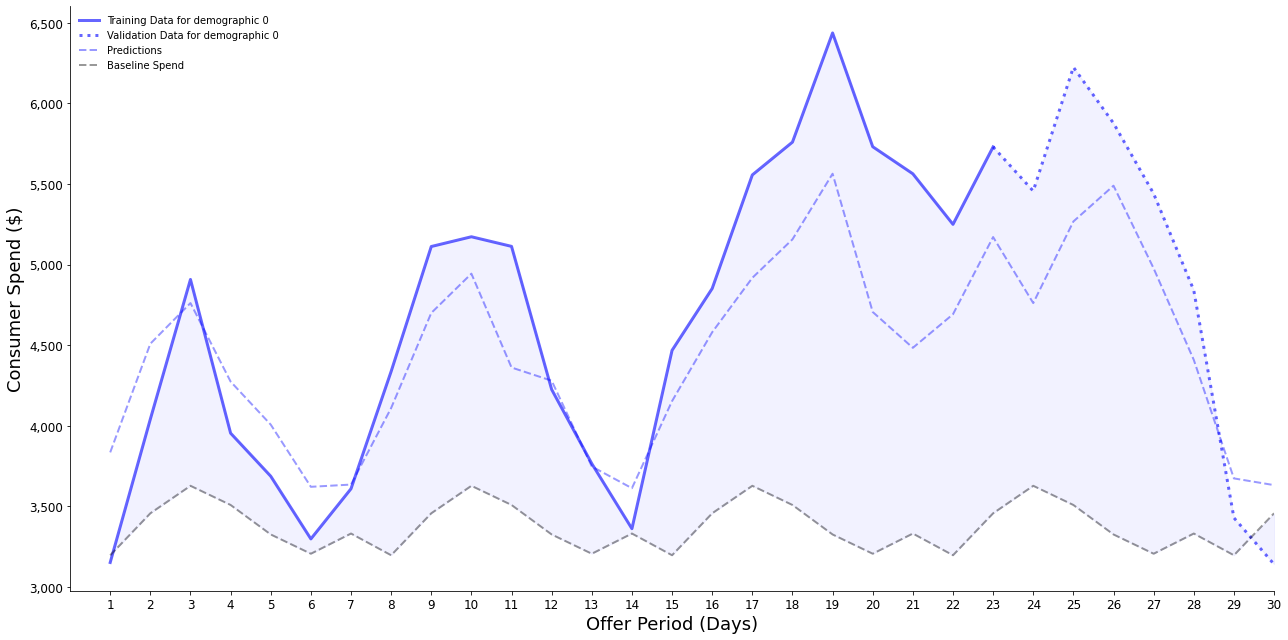

65834.3951396179


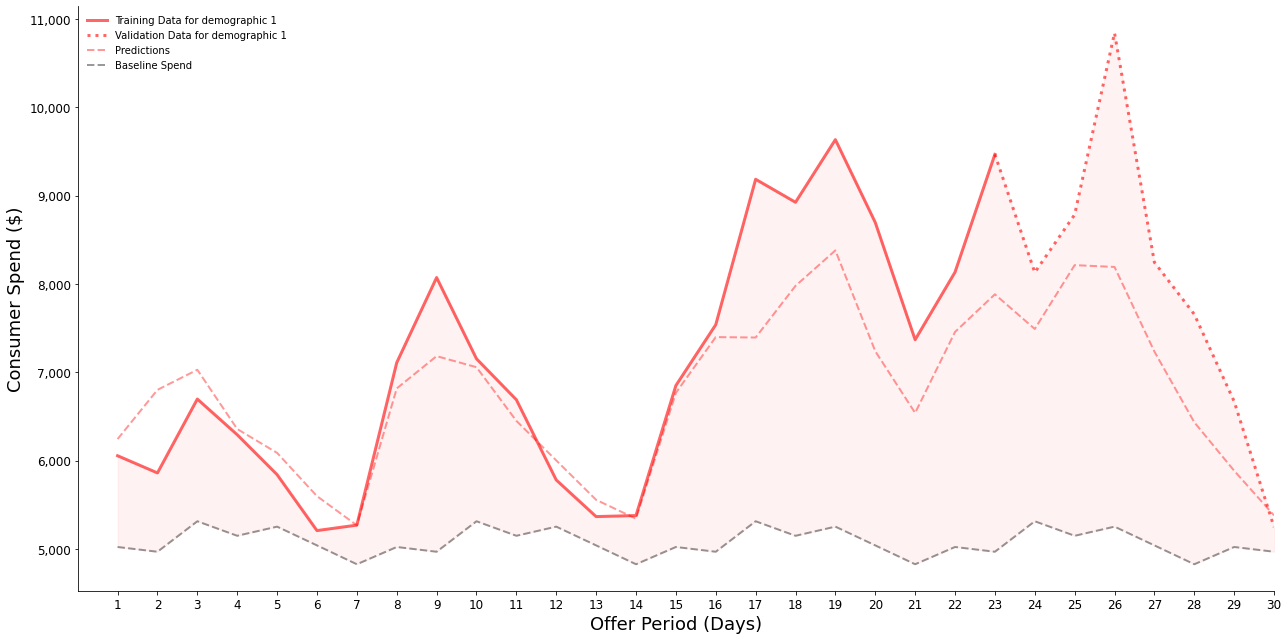

8807.759300975795


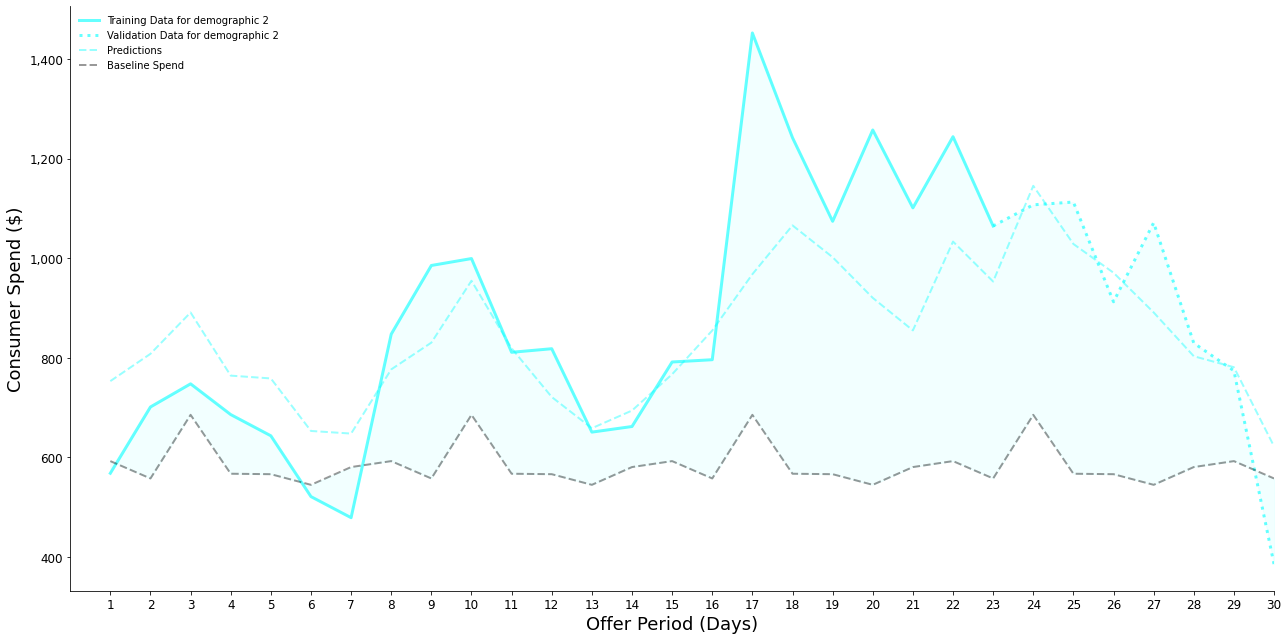

48842.99929123401


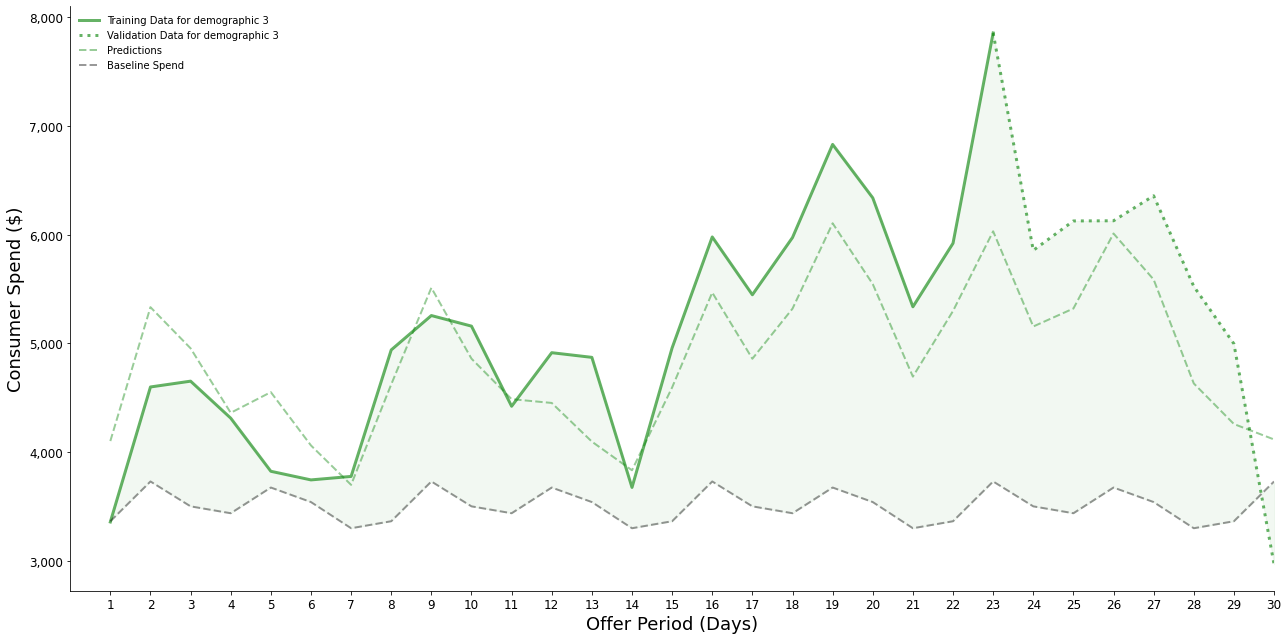

6252.021907186507


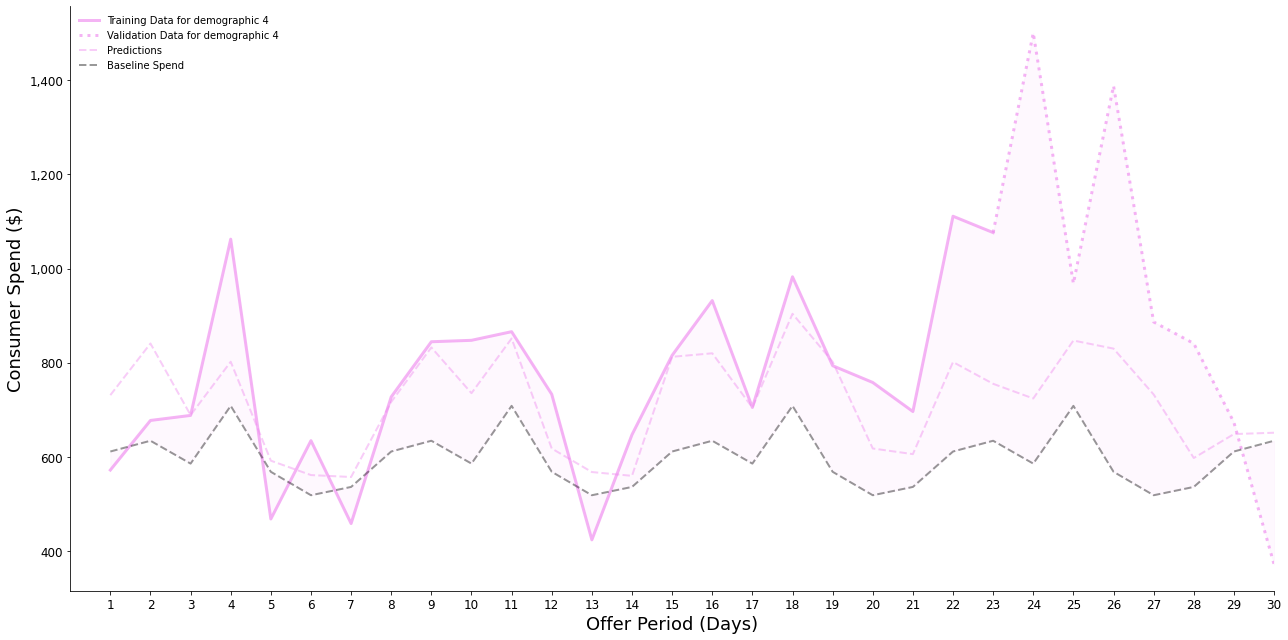

133404.00333965296


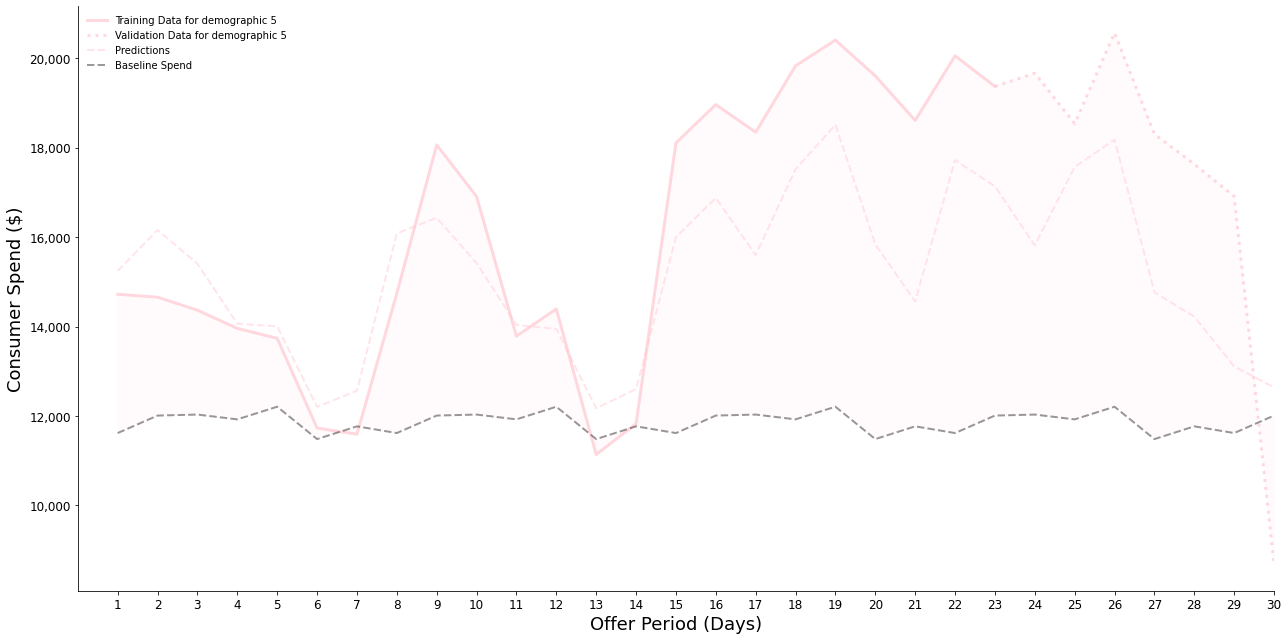

98205.07819255826


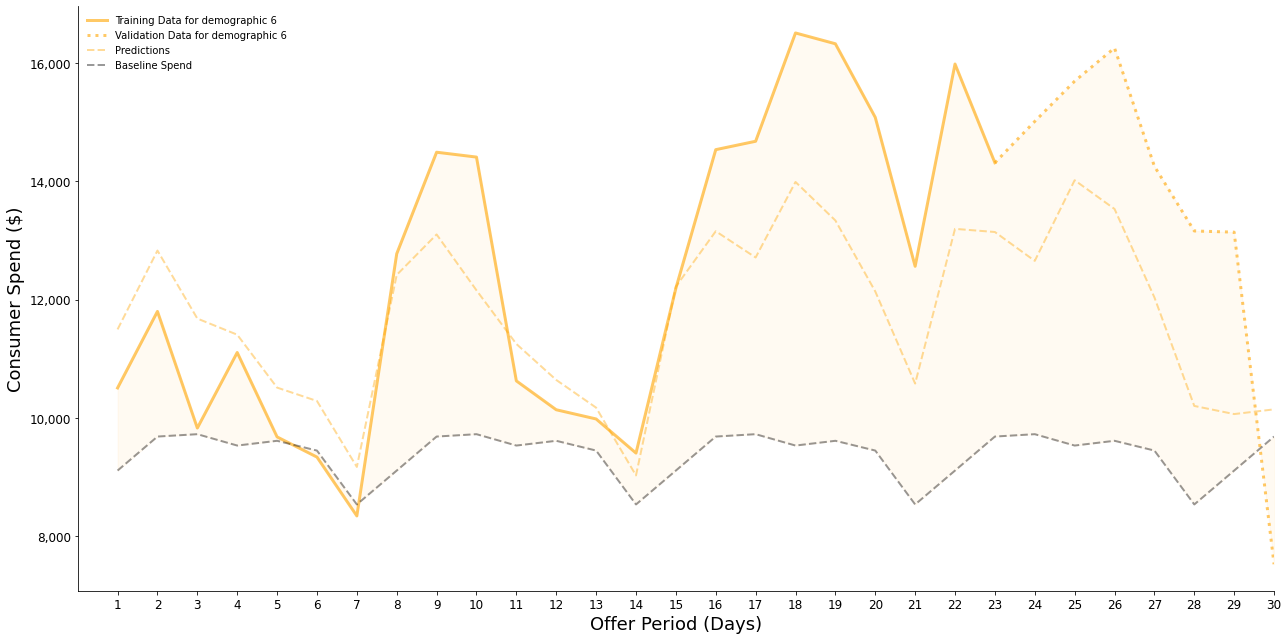

27881.63574417116


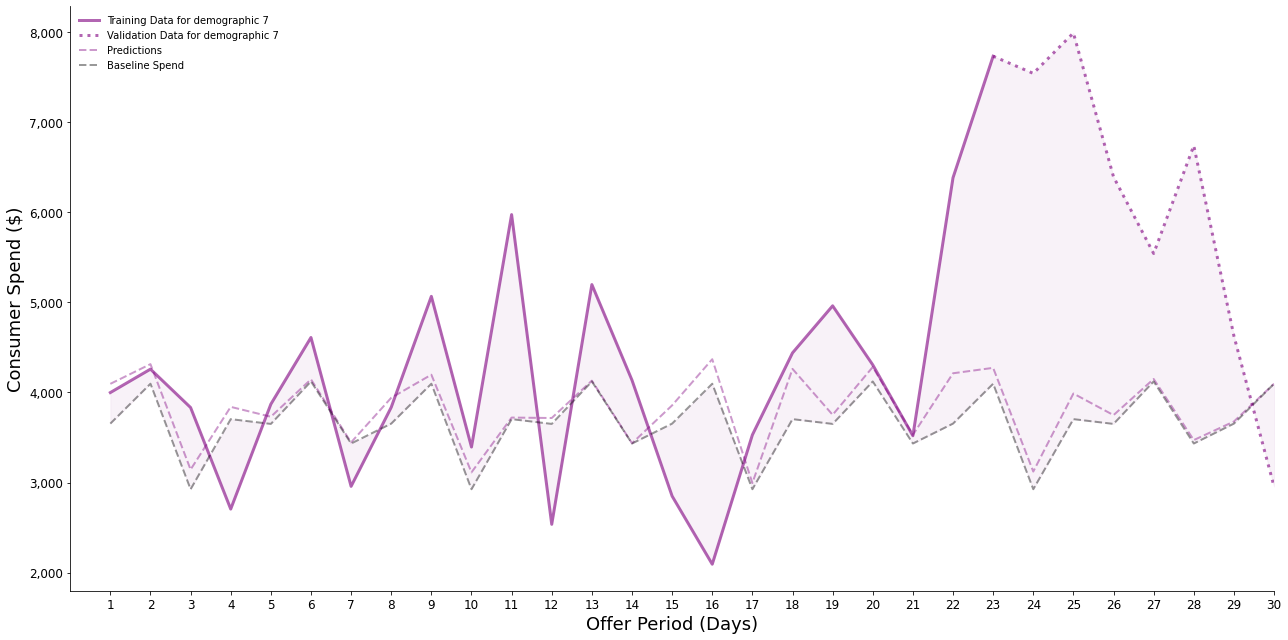

In [116]:
for demographic in [0,1,2,3,4,5,6,7]:
    # creates plot
    fig, ax = plt.subplots(figsize=(18,9))

    # creates a list of colors
    colors = ['blue','red','cyan','green','violet','pink','orange','purple']

    # plot selected demographics
    plot_spend(input_data, demographic, colors[demographic], fill=True)

    # show the plot legend
    ax.legend(loc=2, frameon=False)

    # set the x tick limits
    ax.set_xlim(0, 30)

    # set the x ticks
    ax.set_xticks(list(range(1,31)))

    # set x label
    ax.set_xlabel('Offer Period (Days)', fontsize=18)

    # set y label
    ax.set_ylabel('Consumer Spend ($)', fontsize=18)

    # set size of the axis params
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

    # Adds the comma into y labels
    ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Removes spines and changes layout to tight
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()

    # show/close
    plt.show()


In [169]:
predictions # predicting demographic

,female,male,other,unknown gender,age,person,member joined,income,total transactions,total spend,spend per trans,spend per day,membership length,demographic
0,0,0,0,1,0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,0.0,9,20.40,2.266667,0.680000,76.0,2
1,1,0,0,0,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,3,77.01,25.670000,2.567000,54.0,5
2,0,0,0,1,0,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,0.0,5,10.21,2.042000,0.340333,2.0,2
3,1,0,0,0,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,4,89.99,22.497500,2.999667,63.0,5
4,0,0,0,1,0,a03223e636434f42ac4c3df47e8bac43,2017-08-04,0.0,3,4.65,1.550000,0.155000,51.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16302,1,0,0,0,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,7,20.03,2.861429,0.667667,7.0,1
16303,0,1,0,0,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,7,25.97,3.710000,0.865667,2.0,3
16304,0,1,0,0,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,6,32.07,5.345000,1.069000,78.0,3
16305,1,0,0,0,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,13,178.92,13.763077,5.964000,124.0,5


In [219]:
predictions_one # predicting spend

,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4,0_1.0,0_2.0,0_3.0,0_4.0,0_5.0,0_6.0,0_7.0,prediction
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,2.419834
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,2.419834
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,2.419834
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,2.419834
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,2.419834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,2.393952
62276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,2.393952
62277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,2.393952
62278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,2.393952
